In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import requests as rq
from requests.auth import HTTPBasicAuth
import cv2
import os 
from bs4 import BeautifulSoup
import time
import torch as tor
from torchvision.datasets import ImageFolder
from torchvision import  transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.data import Subset

C:\Users\Arda\.conda\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### HELPER FUNCTIONS

In [2]:
basic = HTTPBasicAuth('**********', '****')

In [3]:
fragments= {"Fragment_1":["Frag1","20230205142449"],
             "Fragment_2": ["Frag2","20230216174557"],
           "Fragment_3":["Frag3","20230215142309"],
           "Fragment_4": ["Frag4","20230222173037"]}

In [4]:
def get_tif_file_names(name,vol_num):
    #name:: file name of the fragment
    #vol_num: File number given fragments volume storage
    
    r=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/volumes/{}".format(name,vol_num),auth=basic)
    page=r.content
    links = BeautifulSoup(page).findAll("a")
    return [i.get("href") for i in links if i.get("href")[-3:]=="tif"]
    

In [5]:
fragment_tif= {}
for key in fragments.keys():
    örn=fragments[key]
    fragment_tif[key]=get_tif_file_names(örn[0],örn[1])

In [6]:
    
def download_file(f_name,name,vol_num,tif):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    #vol_num:: File number given fragments volume storage
    #tif:: .tif file to download
    r_tif=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/volumes/{}/{}".format(name,vol_num,tif),auth=basic)
    try:
        os.mkdir(f_name)
    except:
        pass
    file = open("{}/{}".format(f_name,tif), "wb")
    file.write(r_tif.content)
    file.close()

In [7]:
def download_label(f_name,name):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    r=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface".format(name),auth=basic)
    page=r.content
    links = BeautifulSoup(page).findAll("a")
    label=[i.get("href") for i in links if i.get("href")[-13:]=='inklabels.png'][0]
    
    r_tif=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface/{}".format(name,label),auth=basic)
    try:
        os.mkdir(f_name)
    except:
        pass
    file = open("{}/{}".format(f_name,label), "wb")
    file.write(r_tif.content)
    file.close()

In [8]:
def get_subv_file_names(name):
    #name:: file name of the fragment
    #vol_num: File number given fragments volume storage
    
    r=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface/surface_volume/".format(name),auth=basic)
    page=r.content
    links = BeautifulSoup(page).findAll("a")
    return [i.get("href") for i in links if i.get("href")[-3:]=="tif"]
    

In [9]:
fragment_sub= {"Fragment_1":"Frag1",
             "Fragment_2": "Frag2",
           "Fragment_3":"Frag3",
           "Fragment_4": "Frag4"}

In [10]:
def download_sub_file(f_name,name,tif):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    #vol_num:: File number given fragments volume storage
    #tif:: .tif file to download
    r_tif=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface/surface_volume/{}".format(name,tif),auth=basic)
    file_dir= "Fragment_Samples/{}".format(f_name)
    try:
        os.mkdir(file_dir)
    except:
        pass
    file = open("{}/{}".format(file_dir,tif), "wb")
    file.write(r_tif.content)
    file.close()

frag_1=get_subv_file_names(fragment_sub["Fragment_1"])
for i in frag_1:
    download_sub_file("Fragment_1",fragment_sub["Fragment_1"],i)

# Dataset

In [ ]:
#By taking data storage problem into account:
    #First, a dataset class used for creating iteratable from metas of datas, 
        #calling real data only when actual training happens
    #Second, we create training and validation sets from that data.

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, label_file,image_files, img_dir, transform=None ):
        
        #label_file: file name where ink label image  stored
        #image files: file names where each created vertical slices stored
        #img_dir: main file direction for images
        #transform: transforms image with desired transfrom function.
        
        self.img_labels=image_files
        self.image_dir = img_dir
        
        self.transform = transform
        
        #label of selected fragment loaded and normalized between 0-1
        label = np.amax(cv2.imread(label_file),axis=-1,keepdims=True)/255
        
        label= np.float32(label)
        
        #Reshaping label for fitting torch format.
        self.label= label.reshape([label.shape[2],label.shape[0],label.shape[1]])
   
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        #File direction of selected image is created
        img_path = os.path.join(self.image_dir, self.img_labels[idx] )
        
        #The image loaded
        image = cv2.imread(img_path)
        
        #The image trimmed for training purposes
        image= image[1:,2:,:]
        #image= image.reshape([image.shape[2],image.shape[0],image.shape[1]]) 
        
        #Y axis number of given slice is selected
        label_id= int(self.img_labels[idx][9:-4])
        
        #Corresponding label slice created.
        label_loc= tor.from_numpy(self.label[:,label_id,2:],)
        
        #Batch layer added for the label slice.
        label_loc=tor.unsqueeze(label_loc,0)
        
        #Image transformed, if there is need.
        if self.transform:
            image = self.transform(image)
           
        #Final image and label returned.
        return image, label_loc
   

In [12]:

#Function for, train and validation sets from our  iteratable object.
def train_val_dataset(dataset, val_split=0.25):
    
    #Train and validation ids selected within given test proportion
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    
    #With subset object,final train and valitadion objects created.
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [13]:
#File direction for fragment 1 
direc="Fragment_Samples/Fragment_1"

#List of images' directions
list_dir=os.listdir(direc)

#Horizontal images within all image files.
horizontals= [i for i in list_dir if len(i)==6]

#Folder created for vertical slices.
y_dir="{}/y_axis".format(direc)
try:
    os.mkdir(y_dir)
except:
    pass




In [14]:
#Function detecting slice number of each vertical images.
def sıra(x):
    return int(x[9:-4])

In [ ]:
frag_y=8181*3.24/10000
frag_x=6330*3.24/10000
frag_y,frag_x
seg_y=15798*(7.91)/(10000)
seg_x=23350*(7.91)/(10000)
seg_y,seg_x
seg_frag_y=8181*(7.91)/(10000)
seg_frag_x=6330*(7.91)/(10000)
seg_frag_y,seg_frag_x

In [ ]:
#This code snipped, designed for createing vertical slices from stack of horizantal slices.

volumes=[]

#Iterating over horizontal image files.
for i in horizontals:

        #Loading selected horizontal image and collapesing duplicated channel layer.
        sample=np.amax(cv2.imread("{}/{}".format(direc,i)),axis=-1)
        
        #Appending each horizontal images into a list for concatenating.
        #Adding one dimention for stacking.
        volumes.append(np.expand_dims(sample,0))
        
#Creating stacking all horizontal images.
frag_1=np.concatenate([volumes],axis=0)

#We dont need that extra dimention anymore.
frag_1=np.squeeze(frag_1)
print(frag_1.shape)

#Iterating over y length of the fragment 1 
for slice in range(8182):
    
    #y slice created from each y point.
    cv2.imwrite("{}/y_slices_{}.tif".format(y_dir,slice),frag_1[:,slice,:])

## MODEL FUNCS

In [16]:
def train_one_epoch(epoch_index, tb_writer,model,loss_fn,optimizer,train_loader):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        #Loading datas into GPU storage
        inputs, labels= inputs.to("cuda:0"), labels.to("cuda:0")

        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### SAMPLE ML PIPELINE

#### Model Base Func

In [17]:
from transformers import SegformerForSemanticSegmentation,MobileNetV2ForSemanticSegmentation,AutoImageProcessor

model_checkpoint = "google/deeplabv3_mobilenet_v2_1.0_513"


model_seg = MobileNetV2ForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=3,
    ignore_mismatched_sizes=True,
)

Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### SAMPLE FLOW

In [18]:
label= np.amax(cv2.imread("Fragment_Samples/Fragment_1/inklabels.png"),axis=-1)


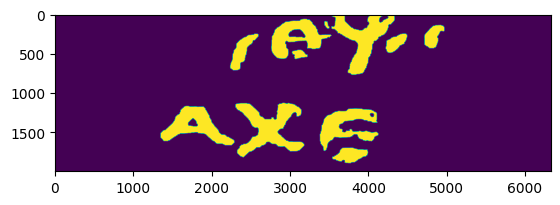

In [19]:
valid=label[500:2500,:]
plt.imshow(valid)

In [20]:
label= cv2.imread("Fragment_Samples/Fragment_1/inklabels.png")
label=label.reshape(3,label.shape[0],label.shape[1])
label= label[:,:,2:]
label= np.float16(label)
label=tor.from_numpy(label)
label.dtype

torch.float16

In [21]:
samp=cv2.imread("Fragment_Samples/Fragment_1/y_axis/y_slices_4000.tif") 
samp=samp.reshape(3,65,6330)
samp= samp[:,1:,2:]
samp=np.expand_dims(samp,axis=0)
samp=np.float32(samp)
mean=samp.mean()
std= samp.std()
samp_sd=(samp-mean)/std
samp_sd=tor.from_numpy(samp_sd)

In [22]:
samp_sd.shape

torch.Size([1, 3, 64, 6328])

In [23]:
image = cv2.imread("Fragment_Samples/Fragment_1/y_axis/y_slices_4000.tif") 
image.shape

(65, 6330, 3)

In [24]:
image= image[1:,2:,:]
image.shape    

(64, 6328, 3)

In [25]:
predict=model_seg(samp_sd).logits
pred_s=tor.squeeze(predict,(0,1))

In [26]:
791*8

6328

In [27]:
predict.shape

torch.Size([1, 3, 8, 791])

In [28]:
gör=np.amax(cv2.imread("Fragment_Samples/Fragment_1/y_axis/y_slices_4000.tif"),-1 )

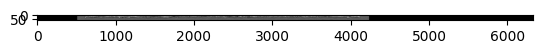

In [29]:
plt.imshow(gör,"gray")

### ANA MODEL 

In [30]:
#For semantic segmentation, transformer models are used. 
#Becouse this models learns from image patterns and creates new image with new segmentation channels.
#First segformer model, becouse segformer was very popular in competation time and there was good proven results.
    #but we couldn't use it, becouse its was to heavy for the local computers GPU
#As final choise we choose Mobilenet, becouse it is designed for being light-weighted.

from transformers import SegformerForSemanticSegmentation,MobileNetV2ForSemanticSegmentation,AutoImageProcessor
class seg_final(tor.nn.Module):
    def __init__(self):
        
        super().__init__()

        self.MobileNetV2=MobileNetV2ForSemanticSegmentation.from_pretrained(
    "google/deeplabv3_mobilenet_v2_1.0_513" #we choose according to benchmark testing at hugging face
    ,num_labels=3  #Actualy we need just one label. But model doesnt response well into that choise

,ignore_mismatched_sizes=True,
)
        
        self.up_sc1= tor.nn.ConvTranspose2d(3,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        self.up_sc2= tor.nn.ConvTranspose2d(1,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        self.up_sc3= tor.nn.ConvTranspose2d(1,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        
        #Activation for binary out for each pixel cell.
        self.act= tor.nn.Sigmoid()
    def forward(self,image):

        #3 channel output collapesed to one
        x= self.MobileNetV2(image).logits.max(axis=2,keepdim=True)[0]
        
        #This model resized image into 1/8 of the original size.
        #We rescale image into original size.
        x= self.up_sc1(x)
        x= self.up_sc2(x)
        x= self.up_sc3(x)
        
        #Final label prediction
        x= self.act(x)
        
        return x
        
        

In [31]:
model_seg= seg_final()

Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Batch SET TRIAL 

In [32]:
#Loading of label data.
label_dir= "Fragment_Samples/Fragment_1/inklabels.png"

#Desired transformation for data.(trans. into tensor object and normalization.)
data_transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=0.485 ,
                             std=0.229)
    ])

#List of y slice image directions
image_list=os.listdir(y_dir)

#Sorting according y axis number.
image_list.sort(key=sıra)

#Reversing for fragment 1
image_list= image_list[:-1]

#Iteratable for training-testing
data_set=CustomImageDataset(label_dir,image_list,y_dir,data_transform)

#Train and validation splits. 
#Validation number selected as multiplayer of 4. Becouse the model outputs 1/4 resized image
sets=train_val_dataset(data_set, val_split=2000)

#Iteratable with batches created for training 
train_data=sets["train"]
train_batches=DataLoader(train_data,batch_size=4,shuffle=True)

#Iteratable with batches created for validation
valid_data=sets["val"]
valid_batches=DataLoader(valid_data,batch_size=4)




In [33]:
#Binary cross entrophy choosed for loss function
loss_bce = tor.nn.BCELoss()

In [34]:
#Loaded model is loaded into GPU storage
model_seg.to("cuda:0")

seg_final(
  (MobileNetV2): MobileNetV2ForSemanticSegmentation(
    (mobilenet_v2): MobileNetV2Model(
      (conv_stem): MobileNetV2Stem(
        (first_conv): MobileNetV2ConvLayer(
          (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (conv_3x3): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (reduce_1x1): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        )
      )
      (layer): ModuleList(
     

In [35]:
#Learning rate and optimizer function initiliazed
l_rate=0.001
optimizer_prop= tor.optim.RMSprop(model_seg.parameters(),lr=l_rate)

In [36]:
#Timestamp selected of creating unique summary and model records.
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#Summary object for given learning session
writer = SummaryWriter('runs/scroll_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

#At the end, model weights with bess validation loss performance will be saved.
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_seg.train(True)
    avg_loss = train_one_epoch(epoch_number, writer,model_seg,loss_bce,optimizer_prop,train_batches)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_seg.eval()

    # Disable gradient computation and reduce memory consumption.
    with tor.no_grad():
        
        #Iterated over each validation batches
        for i, vdata in enumerate(valid_batches):
            
            #Validation inputs and labels loaded to GPU storage
            vinputs, vlabels = vdata
            vinputs, vlabels=vinputs.to("cuda:0"), vlabels.to("cuda:0")
            
            #Model prediction of validation data
            voutputs = model_seg(vinputs)
            
            #Computing loss
            vloss = loss_bce(voutputs, vlabels)
            #Adding losses of all batches
            running_vloss += vloss
    
    #Averaging sum of losses.
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'Models/model_{}_{}'.format(timestamp, epoch_number)
        tor.save(model_seg.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.25208638709783554
LOSS train 0.25208638709783554 valid 0.22787784039974213
EPOCH 2:
  batch 1000 loss: 0.20335707496106625
LOSS train 0.20335707496106625 valid 0.19018380343914032
EPOCH 3:
  batch 1000 loss: 0.183112948410213
LOSS train 0.183112948410213 valid 0.16244329512119293
EPOCH 4:
  batch 1000 loss: 0.16489939698204398
LOSS train 0.16489939698204398 valid 0.14843563735485077
EPOCH 5:
  batch 1000 loss: 0.13918489055521785
LOSS train 0.13918489055521785 valid 0.1229022890329361
EPOCH 6:
  batch 1000 loss: 0.1186794338747859
LOSS train 0.1186794338747859 valid 0.11504430323839188
EPOCH 7:
  batch 1000 loss: 0.09957482110266573
LOSS train 0.09957482110266573 valid 0.10948394984006882
EPOCH 8:
  batch 1000 loss: 0.08332500828197226
LOSS train 0.08332500828197226 valid 0.09781734645366669
EPOCH 9:
  batch 1000 loss: 0.07168670412281063
LOSS train 0.07168670412281063 valid 0.10197071731090546
EPOCH 10:
  batch 1000 loss: 0.0612034811351914
LOSS train 0.0

In [38]:
#Best model loaded.
saved_model = seg_final()
saved_model.load_state_dict(tor.load(model_path))

Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## TEST 

In [39]:
#Test batches created.
test_data= CustomImageDataset(label_dir,image_list,y_dir,data_transform)
test_batches=DataLoader(test_data,batch_size=4)

In [40]:
#Loaded model is loaded into GPU storage
saved_model.to("cuda:0")

seg_final(
  (MobileNetV2): MobileNetV2ForSemanticSegmentation(
    (mobilenet_v2): MobileNetV2Model(
      (conv_stem): MobileNetV2Stem(
        (first_conv): MobileNetV2ConvLayer(
          (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (conv_3x3): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (reduce_1x1): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        )
      )
      (layer): ModuleList(
     

In [41]:

labels=[]
inputs=[]

#Iterated over number  of test batches
for i,  pred in enumerate(test_batches):
    
    input, label = pred
    input= input.to("cuda:0")
    
    with tor.no_grad():
        predict= saved_model(input)
    #For final prediction image, we loaded prediction to CPU
    inputs.append(predict.cpu().detach().numpy())
    labels.append(label.detach().numpy())
    print(i)
   
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [42]:
len(labels),len(inputs)

(2045, 2045)

In [54]:
#Each y axis prediction stacked in to one fragment image.
inputed=np.squeeze(np.concatenate(inputs))
inputed=np.where(inputed>0.5,1,0)

In [55]:
labeled=np.squeeze(np.concatenate(labels))
labeled.shape

(8180, 6328)

In [56]:
outs= "outputs"
try:
    os.mkdir(outs)
except:
    pass

In [57]:
#Predicted fragment image is saved.
output_file= "{}/{}.png".format(outs,model_path[7:])  

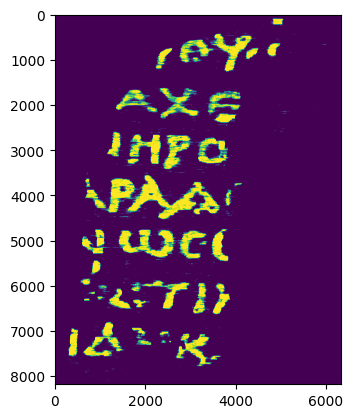

In [58]:
cv2.imwrite(output_file,np.uint8(inputed*255))
plt.imshow(inputed*255)

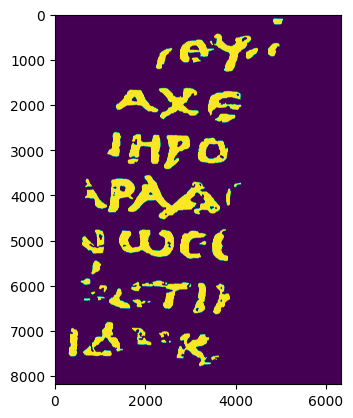

In [48]:
plt.imshow(labeled)

In [49]:
log_excel= "model_logs.xlsx"


In [50]:
#Models from each training trial saved into dataframe.
current_logs= {}
current_logs["Model_Name"]=[model_path[7:]]
current_logs["Learning_Rate"]= [l_rate]
df_current= pd.DataFrame(current_logs)
df_current

,Model_Name,Learning_Rate
0,model_20231230_205916_9,0.001


In [51]:

if log_excel in os.listdir():
    
    logs= pd.read_excel(log_excel)

else:

    logs=pd.DataFrame()


In [52]:
final_logs= pd.concat([logs,df_current])
final_logs

,Model_Name,Learning_Rate,Validation_Loc
0,model_20231230_112919_0,0.001,500 : 2500
1,model_20231230_141727_1,0.010,500 : 2500
2,model_20231230_150505_1,0.005,500 : 2500
3,model_20231230_150505_1,0.005,NaN
4,model_20231230_160153_3,0.005,NaN
5,model_20231230_160153_3,0.005,NaN
6,model_20231230_164949_4,0.001,NaN
7,model_20231230_174601_4,0.001,NaN
8,model_20231230_183640_6,0.001,NaN
0,model_20231230_205916_9,0.001,NaN


In [53]:
final_logs.to_excel(log_excel,index=False)